# IIC-3670 NLP UC



In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import transformers

print(transformers.__version__)

4.36.2


In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("text_classification_notebook", framework="pytorch")

Glue es un benchmark multitarea. Los benchmarks incluyen datos y métrics.

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

## Vamos a trabajar con la tarea Linguistic Acceptability (CoLa)

In [5]:
task = "cola"
batch_size = 16

## Datasets trae glue, lo leemos para la tarea específica.

In [6]:
from datasets import load_dataset, load_metric

actual_task = "cola"
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

<ipython-input-6-073895a4d500>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', actual_task)
/home/marcelo/.local/lib/python3.8/site-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [7]:
print(dataset["train"][0])
print(dataset["validation"][0])

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.", 'label': 1, 'idx': 0}
{'sentence': 'The sailors rode the breeze clear of the rocks.', 'label': 1, 'idx': 0}


## Esta función permite ver algunos de los ejemplos que trae glue para esta tarea

In [8]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(dataset["train"])

,sentence,label,idx
0,The terrier attacked the burglar.,acceptable,6665
1,The president was hoping for a good cake.,acceptable,3488
2,We contributed her with our paycheck.,unacceptable,2725
3,It is beans that I don't like.,acceptable,1503
4,Gilgamesh hasn't kissed Ishtar.,acceptable,8544
5,The man is dancing.,acceptable,5628
6,He failed chemistry because he can't understand it.,acceptable,3792
7,Medea poisoned more children than Jason did.,acceptable,7835
8,There is strangers in that garden.,unacceptable,812
9,Sarah sang the anthem.,acceptable,2476


## Metric depende de la tarea que evaluemos

In [10]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

## Vamos a evaluar un encoder para esta tarea (DistilBERT)

In [11]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/home/marcelo/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Recuerde que el tokenizer esta amarrado al modleo con el que trabajamos

In [12]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Este diccionario permite agrupar las tareas según su formato de entrada

In [13]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

## Usaremos las sentences keys para decidir como ingresar los datos al encoder. En este caso, CoLa es de aceptación de una oración

In [14]:
sentence1_key, sentence2_key = task_to_keys[task]

if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: Our friends won't buy this analysis, let alone the next one we propose.


## La función preprocess aplica el tokenizer al texto del ejemplo y nos entrega los input_ids

In [15]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

## ¿Por qué attention mask va en 1?

In [16]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

## Armamos las batches con la función map

In [17]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

## Num labels está condicionado a la tarea, en CoLa es 2 (clasificación binaria)

In [18]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2


## La tarea en este caso es sequence classification (clasifica la oración completa). Usamos un AutoModelForSequenceClassification y pasamos el model checkpoint.

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, device_map={"":0})

/home/marcelo/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


!pip3 install torchinfo

In [21]:
import torchinfo

print(torchinfo.__version__)

1.8.0


In [22]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

## Definimos las parámetros del entrenamiento. 

In [24]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

## La función compute metrics se define para evaluar el modelo sintonizado. La evaluación se realiza en la partición de validación.

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

## La inclusión de la partición de validación está condicionada a la tarea. En CoLa tenemos partición de validación.

In [26]:
validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

## Estamos listos para sintonizar el encoder en esta tarea

In [27]:
import numpy as np

trainer.train()

wandb: Currently logged in as: marcelo-mendoza-rocha (mendoza-lab). Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.526500,0.473741,0.480825
2,0.354700,0.513625,0.495987
3,0.234700,0.546987,0.546317
4,0.178400,0.698631,0.554702
5,0.145700,0.891578,0.539129
6,0.103600,1.000901,0.524198
7,0.083700,0.988722,0.538738
8,0.068900,1.137990,0.533770
9,0.043500,1.205079,0.551040
10,0.041900,1.175781,0.557883


Checkpoint destination directory distilbert-base-uncased-finetuned-cola/checkpoint-535 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-cola/checkpoint-1070 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-cola/checkpoint-1605 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-cola/checkpoint-2140 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-cola/checkpoint-2675 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=5350, training_loss=0.16851242208035191, metrics={'train_runtime': 283.0971, 'train_samples_per_second': 302.052, 'train_steps_per_second': 18.898, 'total_flos': 458231639391456.0, 'train_loss': 0.16851242208035191, 'epoch': 10.0})

## Y evaluamos en validación usando la métrica del benchmark

In [28]:
trainer.evaluate()

{'eval_loss': 1.1757805347442627,
 'eval_matthews_correlation': 0.557882735147727,
 'eval_runtime': 0.5311,
 'eval_samples_per_second': 1963.734,
 'eval_steps_per_second': 124.263,
 'epoch': 10.0}

## Los pesos quedaron guardados en el directorio distilbert-base-uncased-finetuned-cola

In [29]:
!ls distilbert-base-uncased-finetuned-cola

checkpoint-1070  checkpoint-2675  checkpoint-4280  checkpoint-5350
checkpoint-1605  checkpoint-3210  checkpoint-4815  runs
checkpoint-2140  checkpoint-3745  checkpoint-535


## Vamos a usar pipeline para usar el modelo, lo voy a evaluar usando otras métricas 

In [30]:
from transformers import pipeline

saved_model = pipeline('text-classification', model = 'distilbert-base-uncased-finetuned-cola/checkpoint-2675')

In [31]:
dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 1043
})

In [32]:
predictions = saved_model(dataset['validation']['sentence'])

In [33]:
predictions[:10]

[{'label': 'LABEL_1', 'score': 0.9975041747093201},
 {'label': 'LABEL_1', 'score': 0.9984117746353149},
 {'label': 'LABEL_0', 'score': 0.9910622835159302},
 {'label': 'LABEL_1', 'score': 0.9983686804771423},
 {'label': 'LABEL_0', 'score': 0.9703130722045898},
 {'label': 'LABEL_1', 'score': 0.9982026815414429},
 {'label': 'LABEL_0', 'score': 0.9959883093833923},
 {'label': 'LABEL_0', 'score': 0.8984956741333008},
 {'label': 'LABEL_1', 'score': 0.998150110244751},
 {'label': 'LABEL_1', 'score': 0.9986407160758972}]

## Esta función es para parsear el formato de salida de predictions

In [34]:
def get_label(d):
  return int(d['label'].split('_')[1])

predictions = [get_label(d) for d in predictions]

## Aquí evalúo usando F1

In [35]:
from sklearn.metrics import f1_score

print("f1:",f1_score(dataset['validation']['label'], predictions, average = 'macro'))

f1: 0.7678979791981876


## Y finalmente vemos la matriz de confusión

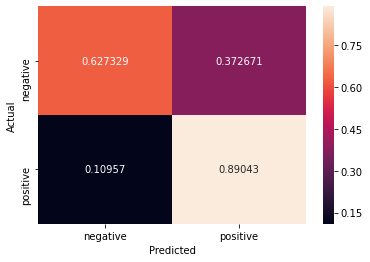

In [36]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive',]
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(dataset['validation']['label'],predictions, normalize = 'true')
plot_cm(cm)